In [2]:
# ------------------------------mount drive-------------------------------------
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Colab\ Notebooks/nonlinear-sys-id/quadrotor\ sys\ id/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/nonlinear-sys-id/quadrotor sys id


# Getting Trajectory Data of Quadrotor

In [3]:
# --------------------------import packages-------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)

from quadrotor_dynamics import system_parameters, euler_to_quaternion, QuadrotorDynamics

# --------------------------ground_truth parameters-----------------------------
I_xx, I_yy, I_zz, Ax, Ay, Az, m, _, _, _, _ = system_parameters()
ground_truth = [1 / m, -Ax / m, -Ay / m, -Az / m,
                (I_yy - I_zz) / I_xx, 1 / I_xx,
                (I_zz - I_xx) / I_yy, 1 / I_yy,
                (I_xx - I_yy) / I_zz, 1 / I_zz]

print("-----------------------------------------------------------------------")
print("ground truth = ", ground_truth)
print("-----------------------------------------------------------------------")

n_epoch = 20              # number trajectories
max_time_hor = 30002      # maximum trajectory length

# ------------------------------disturbacne-------------------------------------
# disturbance: str = "trunc_guass"
# parameter_dist = [0.0, 0.5, 1]  # mean and std

disturbance: str = "uniform"
parameter_dist = [-1, 1]  # lb and ub

seeds_w = range(300, 500) # fixing seeds
w_max = 0.01             # maximum disturbance (required to run set membership)

# ---------------------------------noise----------------------------------------
# c_input: str = "trunc_guass"
# parameter_input = [0.0, 0.1, 1]  # mean and std

c_input: str = "uniform"
parameter_input = [-1, 1]  # lb and ub

mult_u = [1, 0.2, 0.2, 0.2]

seeds_u = range(100, 200)   # fixing seeds

print('------------------Getting Trajectory Data of Quadrotor-----------------')

theta_hat_list = []
Delta_S_list = []
Phi_S_U_list = []

for e in range(n_epoch):

  # q0, q1, q2, q3 = euler_to_quaternion(10 * np.pi/180, 10 * np.pi/180, 10 * np.pi/180)
  q0 = 1
  q1 = 0
  q2 = 0
  q3 = 0
  x0 = [0., 0., 1., 0., 0., 0., q0, q1, q2, q3, 10., 10., 10.]
  qudt = QuadrotorDynamics(c_input, disturbance)
  qudt.get_trajectory_3(x0, max_time_hor, seeds_u[e], seeds_w[e], parameter_input, mult_u, parameter_dist)
  # print("---------------------------------------------------------------------")
  print("e = ", e + 1)
  # qudt.plot_trajectory()

  Delta_S_list.append(qudt.b_s_list)
  Phi_S_U_list.append(qudt.phi_s_u_list)     # nonlinear feature vector

print('-------------------------------Data Saved------------------------------')

-----------------------------------------------------------------------
ground truth =  [2.1367521367521367, -0.5341880341880342, -0.5341880341880342, -0.5341880341880342, -0.8123970345963756, 205.9308072487644, 0.8123970345963756, 205.9308072487644, 0.0, 113.62345188046812]
-----------------------------------------------------------------------
------------------Getting Trajectory Data of Quadrotor-----------------
e =  1
e =  2
e =  3
e =  4
e =  5
e =  6
e =  7
e =  8
e =  9
e =  10
e =  11
e =  12
e =  13
e =  14
e =  15
e =  16
e =  17
e =  18
e =  19
e =  20
-------------------------------Data Saved------------------------------


#  Least-Squares Esimation (LSE)

## Run LSE

In [8]:
import numpy as np
from lse_qdt import run_lst


# time_hor_ = range(1, max_time_hor, 500)
# time_hor_ = [1, 500]
# time_hor_.extend(range(1000, max_time_hor, 1000))

time_hor_ = [1, 500]
time_hor_.extend(range(1000, max_time_hor, 1000))


print('-------------------------------Run LSE---------------------------------')

mean_delta_theta_hat_list = []
std_delta_theta_hat_list = []

for k in range(len(time_hor_)):

    print('T = ' + str(time_hor_[k]))
    delta_theta_hat_list_ = []

    for e in range(n_epoch):
        theta_hat = run_lst(Delta_S_list[e][:time_hor_[k]], Phi_S_U_list[e][:time_hor_[k]])
        delta_theta_hat_list_.append(abs(theta_hat - np.array(ground_truth)))

    mean_delta_theta_hat_list.append(np.mean(np.array(delta_theta_hat_list_), axis=0))
    alpha = 0.05  # 95% confidence interval
    z_score = norm.ppf(1 - alpha / 2)
    coeff = z_score / np.sqrt(n_epoch)
    coeff = 1
    std_delta_theta_hat_list.append(coeff * np.std(np.array(delta_theta_hat_list_), axis=0))


# save array into csv file
name1 = 'lse_data1_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
name2 = 'lse_data2_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
np.savetxt(name1, np.array(mean_delta_theta_hat_list), delimiter = ",")
np.savetxt(name2, np.array(std_delta_theta_hat_list), delimiter = ",")

print('-------------------------------Data Saved------------------------------')

-------------------------------Run LSE---------------------------------
T = 1
T = 500
T = 1000
T = 2000
T = 3000
T = 4000
T = 5000
T = 6000
T = 7000
T = 8000
T = 9000
T = 10000
T = 11000
T = 12000
T = 13000
T = 14000
T = 15000
T = 16000
T = 17000
T = 18000
T = 19000
T = 20000
T = 21000
T = 22000
T = 23000
T = 24000
T = 25000
T = 26000
T = 27000
T = 28000
T = 29000
T = 30000
-------------------------------Data Saved------------------------------


--------------------------------------------------------------------------------
# Plot LSE estimation error

------------------------LSE Estimation Error Plots---------------------


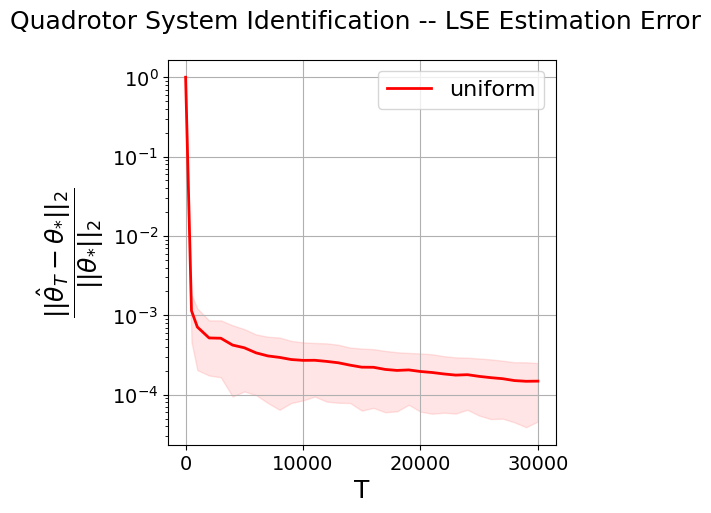

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

linewidth_ = 2.0
alpha_ = 0.1

log_scale = True
separate = False   # True means plot the individual error and total error in the same figure
normalize = True   # True means normalize the individual error when plotting

def plot_lse(mean_theta_hat_list, std_theta_hat_list, ground_truth, time_hor):

  time_hor_ = np.array(time_hor)

  points = []
  errors = []
  c0 = 1
  if normalize:
    c0 = np.linalg.norm(ground_truth)
  for j in range(len(mean_theta_hat_list)):
    points.append(np.linalg.norm(mean_theta_hat_list[j]) / c0)
    errors.append(np.linalg.norm(std_theta_hat_list[j]) / c0)

  if disturbance == 'trunc_guass':
    label_ = 'truncated-Gaussian'
  else:
    label_ = disturbance

  fig = plt.figure(figsize=(5, 5))
  plt.plot(time_hor_, points, color='red', label=label_, linewidth=linewidth_)
  plt.fill_between(time_hor_, np.array(points) - np.array(errors), np.array(points) + np.array(errors), color='red', alpha=alpha_)
  # plt.xticks([1, 5000, 10000])
  plt.xlabel('T')
  if normalize:
    plt.ylabel('$\\dfrac{||\hat{\\theta}_{T} - \\theta_{*}||_{2}}{||\\theta_{*}||_{2}}$')
  else:
    plt.ylabel('$||\hat{\\theta}_{T} - \\theta_{*}||_{2}$')
  plt.legend()
  fig.suptitle('Quadrotor System Identification -- LSE Estimation Error')
  if log_scale:
    plt.yscale('log')

  plt.show()

print('------------------------LSE Estimation Error Plots---------------------')
plot_lse(mean_delta_theta_hat_list, std_delta_theta_hat_list, ground_truth, time_hor_)
